In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace, bernoulli
import scipy.optimize as optimize
import math

Defining constant and writing the function for generating measured data wihtout the noise

In [87]:
N = 201
magnitude = 1.2
mu = 0  # loc
sigma = 1  # beta
alpha = 0
gamma = 0.1
x = np.linspace(-3, 3, N)
params = [1, -8, 4]

def create_y_model(params):
    def y(x): return sum([p*(x**i) for i, p in enumerate(params)])
    return y


The Laplacian noise function

In [89]:
def add_noise_to_true_model(x,N, params, magnitude, alpha, mu, sigma):
    y = create_y_model(params)
    y_true = y(x)
    y_added_noise = y_true + magnitude * \
        (alpha*np.random.normal(mu, sigma, N) +
         (1-alpha)*np.random.laplace(mu, sigma, N))
    return y_added_noise


Adding the outlier noise function

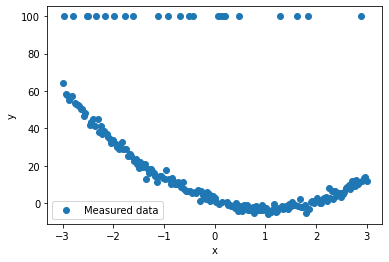

In [91]:
def add_outlier(params, N, magnitude, alpha, mu, sigma, gamma):
    y_added_noise = add_noise_to_true_model(x,
        N, params, magnitude, alpha, mu, sigma)
    data = bernoulli.rvs(size=N, p=gamma)
    for i in range(N):
        if data[i] == 1:
            y_added_noise[i] = 100
    return y_added_noise


y_measured_data = add_outlier(params, N, magnitude, alpha, mu, sigma, gamma)
plt.figure()
plt.scatter(x, y_measured_data, label="Measured data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Splitting the measured data into training, testing and validation

In [93]:

y_traning_set = y_measured_data[0:math.floor(len(y_measured_data)/3)]
x_traning_set = x[0:math.floor(len(x)/3)]

y_testing_set = y_measured_data[math.floor(len(y_measured_data)/3):math.floor(len(y_measured_data)*2/3)]
x_testing_set = x[math.floor(len(x)/3):math.floor(len(x)*2/3)]

y_validation_set = y_measured_data[math.floor(len(y_measured_data)*2/3):]
x_validation_set = x[math.floor(len(x)*2/3):]

Estimting the LS estimator for each mode

In [95]:
def LS_estimator_given_mode(mode, x, y):
    u_tensor_0 = np.reshape(x, (len(x), 1))

    ones_vec = np.ones((len(x), 1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

    for i in range(2, mode):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i), axis=1)

    u_transpose_dot_u = np.dot(u_tensor.T, u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(
        u_transpose_dot_u)  # calculating inverse
    u_transpose_dot_y = np.dot(u_tensor.T, y)  # calculating dot product

    LS_params = np.dot(u_transpose_dot_u_inv, u_transpose_dot_y)
    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    return LS_params

LS_params_affine = LS_estimator_given_mode(2,x_traning_set, y_traning_set)
LS_params_quad = LS_estimator_given_mode(3,x_traning_set,y_traning_set)
LS_params_cube = LS_estimator_given_mode(4,x_traning_set,y_traning_set)

y_hat_LS_affine = create_y_model(LS_params_affine)
y_hat_LS_quad = create_y_model(LS_params_quad)
y_hat_LS_cube = create_y_model(LS_params_cube)

When plotting the different LS estimator modes for the training set, we can clearly see that the affine and quadratic estimator is performing the best, while the cubic estimator has terrible performance

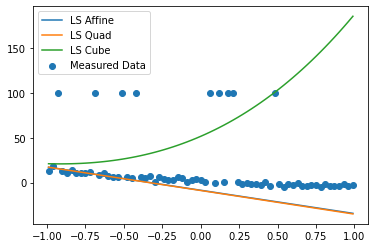

In [97]:
plt.figure()
plt.scatter(x_testing_set,y_testing_set, label= "Measured Data")
plt.plot(x_testing_set,y_hat_LS_affine(x_testing_set), label= "LS Affine")
plt.plot(x_testing_set,y_hat_LS_quad(x_testing_set), label="LS Quad")
plt.plot(x_testing_set,y_hat_LS_cube(x_testing_set),label= "LS Cube")
plt.legend()
plt.show()

The code for estimating the ML estimator for each mode

In [99]:
def log_lik(par_vec,x,y):
    pdf = laplace.pdf
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc=sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale=par_vec[-1])

    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

def ML_estimator_given_mode(mode, N, x,y):
    init_guess = np.zeros(mode+1)
    init_guess[-1] = len(x)

    opt_res = optimize.minimize(fun=log_lik,
                                x0=init_guess,
                                options={'disp': True},
                                args=(x,y))
    MLE_params = opt_res.x[:-1]
    MLE_params = MLE_params.tolist()
    return MLE_params

ML_params_affine = ML_estimator_given_mode(2,N,x_traning_set,y_traning_set)
ML_params_quad = ML_estimator_given_mode(3,N,x_traning_set,y_traning_set)
ML_params_cube = ML_estimator_given_mode(4,N,x_traning_set,y_traning_set)

y_hat_ML_affine = create_y_model(ML_params_affine)
y_hat_ML_quad = create_y_model(ML_params_quad)
y_hat_ML_cube = create_y_model(ML_params_cube)


         Current function value: 270.900525
         Iterations: 17
         Function evaluations: 336
         Gradient evaluations: 81
         Current function value: 269.065481
         Iterations: 35
         Function evaluations: 623
         Gradient evaluations: 123
         Current function value: 269.015023
         Iterations: 23
         Function evaluations: 596
         Gradient evaluations: 98


Plotting the different ML estimators we can see that the quadratic and cubic estimators performed really well. Although the affine estimator was not yielding good result it was still performing reasonaly well compared to the ML estimators

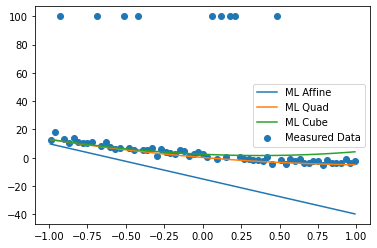

In [100]:
plt.figure()
plt.scatter(x_testing_set,y_testing_set, label= "Measured Data")
plt.plot(x_testing_set,y_hat_ML_affine(x_testing_set), label= "ML Affine")
plt.plot(x_testing_set,y_hat_ML_quad(x_testing_set), label="ML Quad")
plt.plot(x_testing_set,y_hat_ML_cube(x_testing_set),label= "ML Cube")
plt.legend()

Renning the performance index on the testing data for alle the different estimators, we can clearly observe that the best estimator is the quadratic ML estimator as was evident in the plots we did earlier. The second best estimator is the cubic ML estimator. The worst performances came from the LS estimators. 

In [101]:
def performance_index(x_data,y_data,params):
    y_hat_model = create_y_model(params)
    y_hat = y_hat_model(x_data)

    performance = 0
    for i in range(len(y_data)):
        performance += abs(y_data[i] - y_hat[i])
    return performance

performance_LS_affine = performance_index(x_testing_set,y_testing_set, LS_params_affine)
performance_LS_quad = performance_index(x_testing_set,y_testing_set, LS_params_quad)
performance_LS_cube = performance_index(x_testing_set,y_testing_set, LS_params_cube)
performance_ML_affine = performance_index(x_testing_set,y_testing_set, ML_params_affine)
performance_ML_quad = performance_index(x_testing_set,y_testing_set, ML_params_quad)
performance_ML_cube = performance_index(x_testing_set,y_testing_set, ML_params_cube)

print("LS Affine: ", performance_LS_affine)
print("LS Quad: ", performance_LS_quad)
print("LS Cube: ", performance_LS_cube)
print("ML Affine: ", performance_ML_affine)
print("ML Quad: ", performance_ML_quad)
print("ML Cube: ", performance_ML_cube)

LS Affine:  1662.5771103211305
LS Quad:  1681.5744939718413
LS Cube:  4475.585107256561
ML Affine:  2066.210291534851
ML Quad:  973.7625424503735
ML Cube:  1021.0821063426866


In the final part of our assignment i have plotted all the estimators as a function of gamma. If one scrolls past all the warnings one can see the plot at the end. I have choose to exclude the LS cubic estimator from the plots because it was too large and so streched out the graph too much and made it too difficult to compare the perforamance index of the other estimators. 
The most robust estimators seems to be the LS affine estimator which has the least amount and least rapid spikes in it's performance. However it is clear that the LS affine estimator is not the best estimator if gamma is less than 0.2.
The ML quadratic estimator have really good performance in the range gamma = 0 to 0.15, after that it spikes and,but then for gamma > 0.25, the spike ends and it becomes a relativelly good estimator.
To me it becomes clear that the ML estimators have the best performances on average when gamma is either < 0.2 or > 0.4. In between there the LS affine estimator is sometimes good. For gamma > 0.5 all the estimators becomes equally good. At least from what i can see in my plots. To answer the quesiton a) The LS affine estimator degrades least and b) the ML quadratic estimator performes the best 

         Current function value: 142.102576
         Iterations: 23
         Function evaluations: 420
         Gradient evaluations: 102
         Current function value: 115.435949
         Iterations: 28
         Function evaluations: 626
         Gradient evaluations: 123
         Current function value: 115.008290
         Iterations: 53
         Function evaluations: 1037
         Gradient evaluations: 172
         Current function value: 201.454826
         Iterations: 25
         Function evaluations: 415
         Gradient evaluations: 101
         Current function value: 191.707810
         Iterations: 35
         Function evaluations: 672
         Gradient evaluations: 133
         Current function value: 191.776975
         Iterations: 20
         Function evaluations: 601
         Gradient evaluations: 99
         Current function value: 221.214440
         Iterations: 22
         Function evaluations: 480
         Gradient evaluations: 117
         Current function value: 2

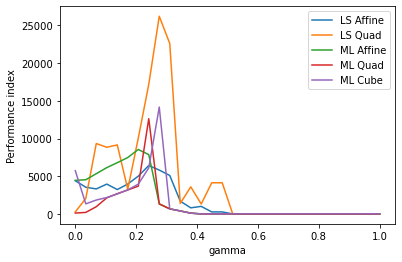

In [102]:
def plot_LS_ML_func_of_gamma(x,params, N, magnitude, alpha, mu, sigma):
    gamma = np.linspace(0,1,30)
    LS_affine_performance_vector = [0]*len(gamma)
    LS_quad_performance_vector = [0]*len(gamma)
    LS_cube_performance_vector = [0]*len(gamma)
    ML_affine_performance_vector = [0]*len(gamma)
    ML_quad_performance_vector = [0]*len(gamma)
    ML_cube_performance_vector = [0]*len(gamma)


    y = create_y_model(params)
    y_true = y(x)
    y_added_noise = y_true + magnitude * \
        (alpha*np.random.normal(mu, sigma, N) +
        (1-alpha)*np.random.laplace(mu, sigma, N))

    x_traning_set = x[0:math.floor(len(x)/3)]
    x_testing_set = x[math.floor(len(x)/3):math.floor(len(x)*2/3)]
    x_validation_set = x[math.floor(len(x)*2/3):]

    for j in range(len(gamma)):
        data = bernoulli.rvs(size=N, p=gamma[j])
        for i in range(N):
            if data[i] == 1:
                y_added_noise[i] = 100

        y_measured_data = y_added_noise
        y_traning_set = y_measured_data[0:math.floor(len(y_measured_data)/3)]
        y_testing_set = y_measured_data[math.floor(len(y_measured_data)/3):math.floor(len(y_measured_data)*2/3)]
        y_validation_set = y_measured_data[math.floor(len(y_measured_data)*2/3):]
        
        LS_params_affine = LS_estimator_given_mode(2,x_traning_set, y_traning_set)
        LS_params_quad = LS_estimator_given_mode(3,x_traning_set,y_traning_set)
        LS_params_cube = LS_estimator_given_mode(4,x_traning_set,y_traning_set)

        ML_params_affine = ML_estimator_given_mode(2,N,x_traning_set,y_traning_set)
        ML_params_quad = ML_estimator_given_mode(3,N,x_traning_set,y_traning_set)
        ML_params_cube = ML_estimator_given_mode(4,N,x_traning_set,y_traning_set)


        LS_affine_performance_vector[j] = performance_index(x_validation_set,y_validation_set, LS_params_affine)
        LS_quad_performance_vector[j] = performance_index(x_validation_set,y_validation_set, LS_params_quad)
        LS_cube_performance_vector[j] = performance_index(x_validation_set,y_validation_set, LS_params_cube)
        ML_affine_performance_vector[j] = performance_index(x_validation_set,y_validation_set, ML_params_affine)
        ML_quad_performance_vector[j] = performance_index(x_validation_set,y_validation_set, ML_params_quad)
        ML_cube_performance_vector[j] = performance_index(x_validation_set,y_validation_set, ML_params_cube)


    plt.figure()
    plt.plot(gamma, LS_affine_performance_vector, label="LS Affine")
    plt.plot(gamma, LS_quad_performance_vector, label="LS Quad")
    #plt.plot(gamma, LS_cube_performance_vector, label="LS Cube")
    plt.plot(gamma, ML_affine_performance_vector, label="ML Affine")
    plt.plot(gamma, ML_quad_performance_vector, label="ML Quad")
    plt.plot(gamma, ML_cube_performance_vector, label="ML Cube")
    plt.legend()
    plt.xlabel('gamma')
    plt.ylabel('Performance index')
    plt.show()

plot_LS_ML_func_of_gamma(x,params, N, magnitude, alpha, mu, sigma)